# ML Capstone Project 1 - Historical Structures Classification .. - Part 2

This notebook contains the code implementation and comments for part 2 of the Capstone project 1

## Import libraries

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

## Load the datasets

In [116]:
user_df = pd.read_csv('user.csv')
tourism_df = pd.read_excel('tourism_with_id.xlsx')
rating_df = pd.read_csv('tourism_rating.csv')

## An overview of the datasets

In [117]:
print('user.csv \n')
user_df.head()


user.csv 



,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [118]:
print('tourism_with_id.xlsx \n')
tourism_df.head()

tourism_with_id.xlsx 



,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In one of the tasks, we are required to study the categories in the tourism data. For that we need to translate the categories from Indonesian to English. This has been done in google translate.

In [119]:
list(tourism_df['Category'].unique())

['Budaya',
 'Taman Hiburan',
 'Cagar Alam',
 'Bahari',
 'Pusat Perbelanjaan',
 'Tempat Ibadah']

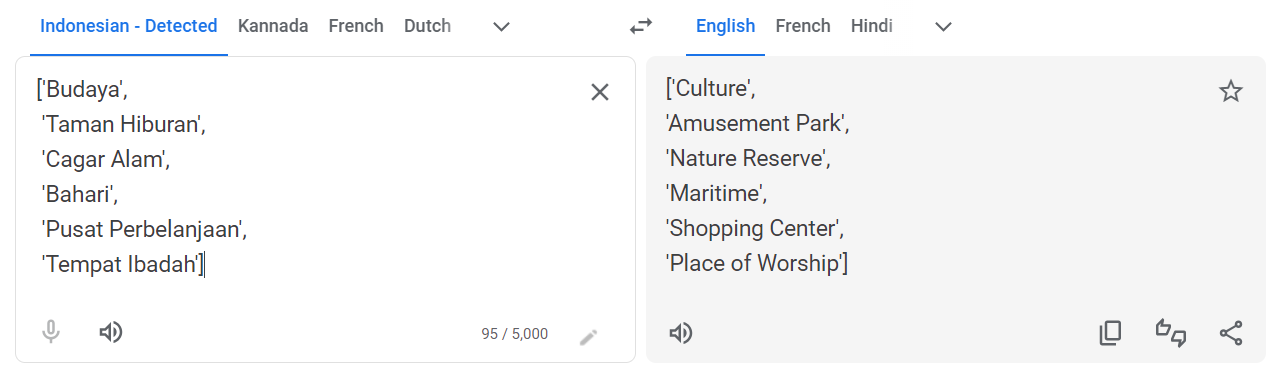

In [120]:
translate_dict=dict(zip(list(tourism_df['Category'].unique()), ['Culture', 'Amusement Park', 'Nature Reserve', 'Maritime', 'Shopping Center', 'Place of Worship']))
tourism_df['Category'] = tourism_df['Category'].map(translate_dict)
tourism_df['Category'].head()

0           Culture
1           Culture
2    Amusement Park
3    Amusement Park
4    Amusement Park
Name: Category, dtype: object

In [121]:
print('tourism_rating.csv \n')
(rating_df.head())

tourism_rating.csv 



,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [122]:
print('******NUMBER OF ROWS AND COLUMNS IN EACH DATASET*******')
print('\n\n user.csv \n\n')
print(user_df.shape)
print('\n\n tourism_with_id.xlsx \n\n')
print(tourism_df.shape)
print('\n\n tourism_rating.csv \n\n')
print((rating_df.shape))

******NUMBER OF ROWS AND COLUMNS IN EACH DATASET*******


 user.csv 


(300, 3)


 tourism_with_id.xlsx 


(437, 11)


 tourism_rating.csv 


(10000, 3)


## Check for Nulls

In [123]:
# Check for missing values
print('\n\n user.csv \n\n')
print(user_df.isnull().sum())
print('\n\n tourism_with_id.xlsx \n\n')
print(tourism_df.isnull().sum())
print('\n\n tourism_rating.csv \n\n')
print(rating_df.isnull().sum())



 user.csv 


User_Id     0
Location    0
Age         0
dtype: int64


 tourism_with_id.xlsx 


Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64


 tourism_rating.csv 


User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64


There are a few nulls in Time_Minutes column of tourism_with_id table. This can be ignored as this column is not used for this project

## Check and drop duplicates

In [124]:
print('\n\n user.csv \n\n')
print(user_df.duplicated().sum())
print('\n\n tourism_with_id.xlsx \n\n')
print(tourism_df.duplicated().sum())
print('\n\n tourism_rating.csv \n\n')
print(rating_df.duplicated().sum())

# Remove duplicates if any
user_df = user_df.drop_duplicates()
tourism_df = tourism_df.drop_duplicates()
rating_df = rating_df.drop_duplicates()



 user.csv 


0


 tourism_with_id.xlsx 


0


 tourism_rating.csv 


79


79 duplicated columns have been removed from tourism_rating table

## Analyze Tourist Group

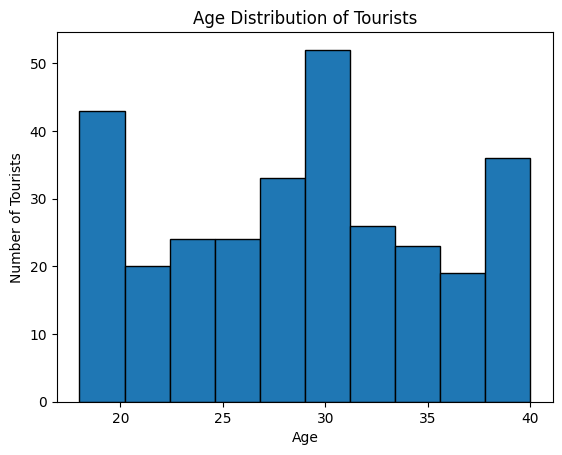

In [125]:
plt.hist(user_df['Age'], bins=10, edgecolor='black')
plt.title('Age Distribution of Tourists')
plt.xlabel('Age')
plt.ylabel('Number of Tourists')
plt.show()

Following points can be made about the age of tourists who have given the rating:

1. There are a high number of tourists with age close to 30 years
2. After that, the next highest age group is close to 20 and 40.
3. Tourists with ages apart from already mentioned is comparatively lesser.

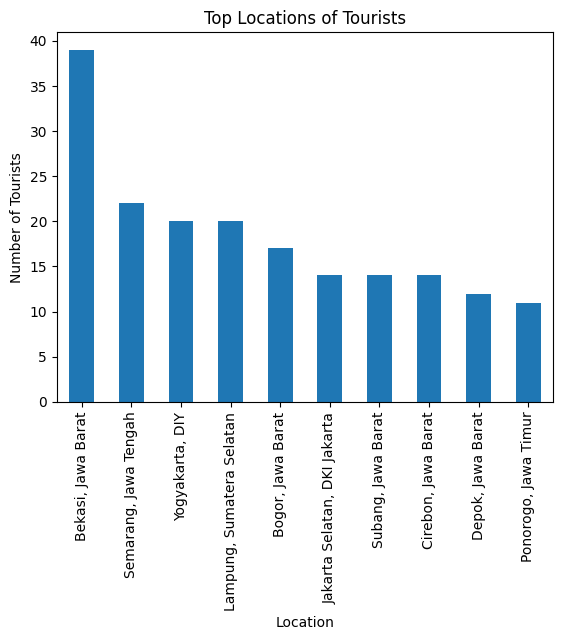

In [126]:
# Count the number of users from each location
location_counts = user_df['Location'].value_counts()

# Plot the top locations
location_counts.head(10).plot(kind='bar')
plt.title('Top Locations of Tourists')
plt.xlabel('Location')
plt.ylabel('Number of Tourists')
plt.show()

Bekasi, Jawa Barat is the most popular destination by far exceeding other places.

## Explore Locations and Categories of Tourist Spots

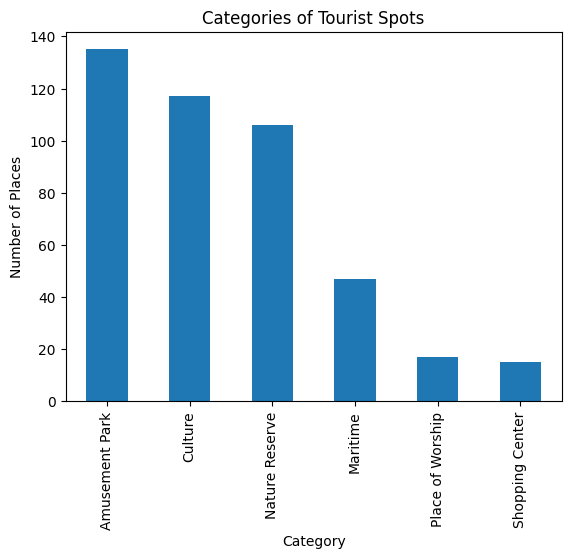

In [127]:
# Count the number of places in each category
category_counts = tourism_df['Category'].value_counts()

# Plot the categories
category_counts.plot(kind='bar')
plt.title('Categories of Tourist Spots')
plt.xlabel('Category')
plt.ylabel('Number of Places')
plt.show()

1. Amusement Park and Culture are the most popular categories
2. Place of Worhip and Shopping Center are least popular

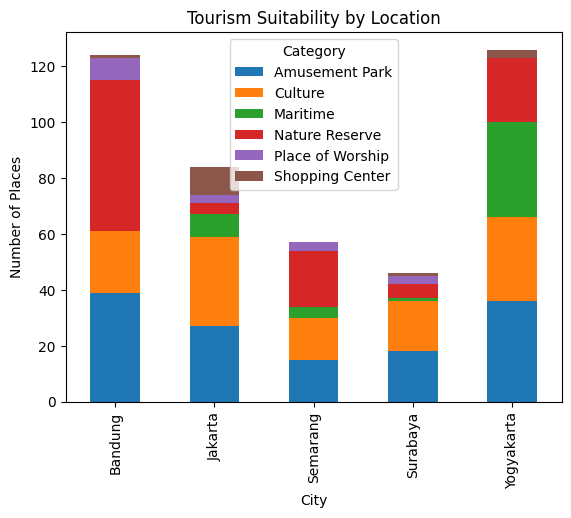

In [128]:
# Group by city and category
city_category = tourism_df.groupby(['City', 'Category']).size().unstack().fillna(0)

# Plot the data
city_category.plot(kind='bar', stacked=True)
plt.title('Tourism Suitability by Location')
plt.xlabel('City')
plt.ylabel('Number of Places')
plt.show()

The distribution of categories are different in differnt cities. Bandung and Yogyakarta offer more places for the tourists as compared to other 3 cities.

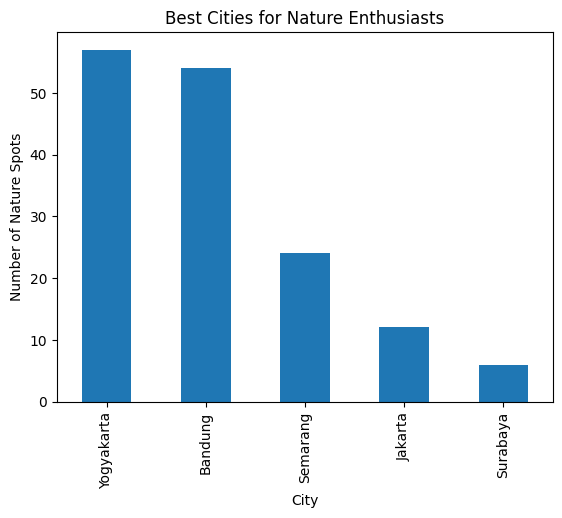

In [129]:
# Filter for nature-related categories
nature_categories = ['Nature Reserve', 'Maritime']
nature_spots = tourism_df[tourism_df['Category'].isin(nature_categories)]

# Count the number of nature spots in each city
nature_city_counts = nature_spots['City'].value_counts()

# Plot the data
nature_city_counts.plot(kind='bar')
plt.title('Best Cities for Nature Enthusiasts')
plt.xlabel('City')
plt.ylabel('Number of Nature Spots')
plt.show()

Same trend can be seen for Nature categories. Once again, Bandung and Yogyakarta are the best options for nature lovers

## Combine Data and Analyze Tourist Spots

In [130]:
# Merge the datasets
combined_df = pd.merge(rating_df, tourism_df, on='Place_Id')
combined_df = pd.merge(combined_df, user_df, on='User_Id')

# Display the first few rows of the combined dataset
combined_df.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Location,Age
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:Í¶...,Culture,Yogyakarta,75000,4.6,90.0,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416,"Semarang, Jawa Tengah",20
1,1,344,2,Pantai Marina,Pantai Marina (bahasa Jawa: Í¶•Í¶±Í¶∂Í¶±Í¶∂Í¶Ç...,Maritime,Semarang,3000,4.1,NaN,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329,"Semarang, Jawa Tengah",20
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Amusement Park,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,"Semarang, Jawa Tengah",20
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Culture,Semarang,10000,4.5,60.0,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602,"Semarang, Jawa Tengah",20
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Culture,Yogyakarta,0,4.0,NaN,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151,"Semarang, Jawa Tengah",20


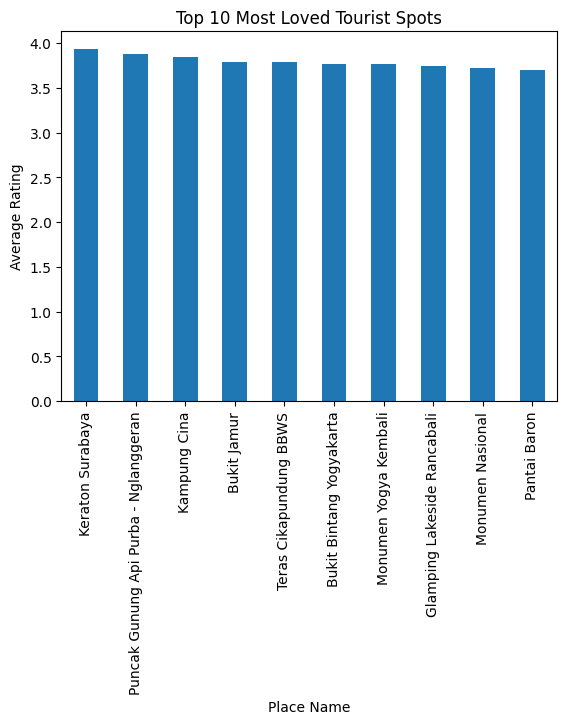

In [131]:
# Calculate the average rating for each place
place_ratings = combined_df.groupby('Place_Name')['Place_Ratings'].mean().sort_values(ascending=False)

# Plot the top 10 most loved places
place_ratings.head(10).plot(kind='bar')
plt.title('Top 10 Most Loved Tourist Spots')
plt.xlabel('Place Name')
plt.ylabel('Average Rating')
plt.show()

Amongst all the places visited by the tourists, Keraton Surabaya enjoys the highest rating. However, we see that there is not a significant difference in ratings between the top 10 rate places.

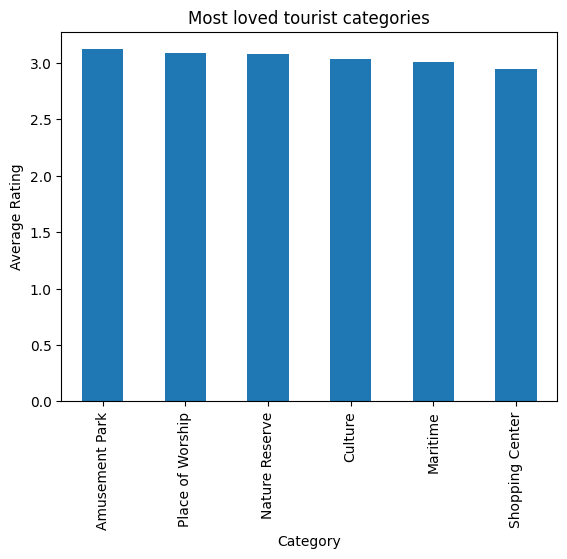

In [132]:
# Calculate the average rating for each city
city_ratings = combined_df.groupby('Category')['Place_Ratings'].mean().sort_values(ascending=False)

# Plot the data
city_ratings.plot(kind='bar')
plt.title('Most loved tourist categories')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.show()

Amusement Park is the most loved category and Shopping Center is the least preferred one

## Build a Recommender Model

Recommeder system implemented using cosine similarity

In [133]:
pivot_table = combined_df.pivot_table(index='User_Id', columns='Place_Name', values='Place_Ratings')

pivot_table.fillna(0, inplace=True)

sparse_matrix = csr_matrix(pivot_table.values)

user_similarity = cosine_similarity(sparse_matrix)

user_similarity_df = pd.DataFrame(user_similarity, index=pivot_table.index, columns=pivot_table.index)

def get_place_recommendations(place_name, num_recommendations=5):
    place_ratings = pivot_table[place_name]
    similarity_score = pivot_table.corrwith(place_ratings)
    similarity_score_df = pd.DataFrame(similarity_score, columns=['similarity_score'])
    similarity_score_df.dropna(inplace=True)
    similarity_score_df.sort_values('similarity_score', ascending=False, inplace=True)
    
    recommendations = similarity_score_df.head(num_recommendations).index.tolist()
    
    return recommendations

current_tourist_location = 'Monumen Nasional'
recommendations = get_place_recommendations(current_tourist_location)
print(f"Place recommendations for {current_tourist_location}: {recommendations}")

Place recommendations for Monumen Nasional: ['Monumen Nasional', 'Wisata Mangrove Tapak', 'Danau Rawa Pening', 'Museum Sonobudoyo Unit I', 'Dunia Fantasi']


Example shown for recommendations for a user who has visited Monumen Nasional. The function in a similar way for other places too.